В данном ноутбуке представлены эксперименты с обычными полносвязными нейросетями на расширенных данных. Попытаемся увеличить датасет, разбив каждый релиз на абзацы и считая каждый абзац отдельным наблюдением.

In [121]:
from sklearnex import patch_sklearn
patch_sklearn()

import re
import sys
import os

import numpy as np
from tqdm import tqdm
import pandas as pd
from pymystem3 import Mystem
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import LabelEncoder
from gensim.models import word2vec
from pymorphy3 import MorphAnalyzer
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from navec import Navec
import gensim.downloader as api
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch
import seaborn as sns
import warnings

from sklearn.metrics import (
    accuracy_score,
    f1_score,
    recall_score,
    precision_score,
    roc_auc_score,
    confusion_matrix,
    classification_report,
)

RANDOM_STATE = 41825352

sns.set_style("whitegrid")
warnings.filterwarnings('ignore')

torch.set_float32_matmul_precision('medium')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

metrics = pd.read_csv('metrics.csv', index_col=0)

Intel(R) Extension for Scikit-learn* enabled (https://github.com/uxlfoundation/scikit-learn-intelex)


Загрузим данные которые были предобработаны в ноутбуке `min_baseline.ipynb`.

In [122]:
X = pd.read_csv("../data/x.csv", index_col="date")
y = pd.read_csv("../data/y.csv", index_col="date").iloc[:, 0]

Следующая функция разбивает текст на абзацы, удаляя абзацы с количеством слов < 10

In [123]:
def aug_release(release):
    release = release.replace('\xa0', ' ').replace('\r', '')
    splitted_filtered = [x for x in release.split('\n') if len(x.split(' ')) > 10]
    return splitted_filtered


In [ ]:
# Приклеем таргет на время к признакам
X['target_categorial'] = y

# Список наблюдений для нового датасета
new_list = []

# Здесь будет храниться соответвие индексов расширенного датасета - первоначальному
aug_release_indexes = []


idx = 0
for index, row in X.iterrows():
    ar = aug_release(row['release'])
    tmp_idx = []
    for pos, s in enumerate(ar):
        tmp_row = row.copy()
        tmp_row['release'] = s

        # Добавляем новый признак - позиция абзаца в оригинальном релизе
        tmp_row['position'] = pos
        new_list.append(tmp_row)
        tmp_idx.append(idx)
        idx += 1
    aug_release_indexes.append(tmp_idx)

X_aug = pd.DataFrame(new_list)
X_aug

,title,release,inflation,rate,usd,usd_cur_change_relative,target_categorial,position
2013-09-13,О процентных ставках по операциям Банка России,Департамент внешних и общественных связей Банк...,6.51,5.5,32.6731,0.994294,0.0,0
2013-10-14,О ключевой ставке Банка России,"Пресс-служба Банка России сообщает, что Совет ...",6.14,5.5,32.2663,0.987549,0.0,0
2013-10-14,О ключевой ставке Банка России,"ключевую ставку Банка России на уровне 5,50% г...",6.14,5.5,32.2663,0.987549,0.0,1
2013-11-08,О ключевой ставке Банка России,Совет директоров Банка России 8 ноября 2013 го...,6.27,5.5,32.3803,1.003533,0.0,0
2013-11-08,О ключевой ставке Банка России,"ключевую ставку Банка России на уровне 5,50% г...",6.27,5.5,32.3803,1.003533,0.0,1
...,...,...,...,...,...,...,...,...
2025-03-21,Банк России принял решение сохранить ключевую ...,На среднесрочном горизонте баланс рисков для и...,10.06,21.0,84.3955,0.927104,0.0,9
2025-03-21,Банк России принял решение сохранить ключевую ...,Банк России исходит из объявленных параметров ...,10.06,21.0,84.3955,0.927104,0.0,10
2025-03-21,Банк России принял решение сохранить ключевую ...,2 апреля 2025 года Банк России опубликует Резю...,10.06,21.0,84.3955,0.927104,0.0,11
2025-03-21,Банк России принял решение сохранить ключевую ...,Следующее заседание Совета директоров Банка Ро...,10.06,21.0,84.3955,0.927104,0.0,12


В итоге увеличили датасет в 15 раз

In [125]:
y_aug = X_aug['target_categorial']
X_aug = X_aug.drop(columns='target_categorial')
X = X.drop(columns='target_categorial')

Предобработаем тексты пресс-релизов.

In [126]:
# инициализируем лемматизатор
mystem = Mystem()

# загружаем стоп-слова
STOP_WORDS = set(stopwords.words("russian"))


# функция для препроцессинга текста
def preprocessor(text):

    # приводим к нижнему регистру
    text = text.lower()

    # удаляем все символы, кроме пробелов и русских букв.
    regex = re.compile("[^а-я А-ЯЁё]")
    text = regex.sub(" ", text)

    # лемматизируем тексты
    text = " ".join(mystem.lemmatize(text))

    # удаляем стоп-слова
    text = " ".join([word for word in text.split() if word not in STOP_WORDS])
    return text


Xpreproc = X_aug.release.apply(preprocessor)

Кодируем тексты при помощи TF-IDF:

In [127]:
vectorizer = TfidfVectorizer(max_df=0.9, min_df=8)
tf_idf = vectorizer.fit_transform(Xpreproc).todense()

Подготавливаем тензоры и отправляем их на GPU:

In [128]:
target_enc = LabelEncoder()
y_enc = target_enc.fit_transform(y_aug)

data1 = torch.tensor(tf_idf, dtype=torch.float).to(device)
y1 = torch.tensor(y_enc, dtype=torch.long).to(device)

In [129]:
data1.size(), y1.size()

(torch.Size([1457, 743]), torch.Size([1457]))

Для чистоты эксперимента, не меняем структуру сети

In [130]:
class TfIdfClassifier(nn.Module):
    def __init__(self, in_features, out_classes):
        super().__init__()

        self.classifier = nn.Sequential(
            nn.Linear(in_features, 2048),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(2048, 1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, out_classes),
            nn.Softmax()
        )

    def forward(self, x):
        return self.classifier(x)

Создаем и обучаем сеть. Также не меняем принцип трейна и теста. Учим на абзацах соответствующих threshold предыдущих релизов и предсказываем все абзацы следующего релиза (итоговый предикт считаем по среднему значению вероятностей)

In [131]:
def train(X, y, aug_release_indexes, num_epochs, factory, start_from=30):
    y_preds = []
    y_preds_proba = []

    prog = tqdm(range(start_from, len(aug_release_indexes)))
    for threshold in prog:        
        train_idx = sum(aug_release_indexes[:threshold], [])
        ds = TensorDataset(X[train_idx], y[train_idx])
        dl = DataLoader(ds, 32, shuffle=False)
        
        model, optimizer, scheduler = factory()
        model.to(device)
        loss_function = nn.CrossEntropyLoss()

        model.train()
        for epoch in range(num_epochs):
            loss = None
            for bx, by in dl:
                model.zero_grad()
                probs = model(bx)
                loss = loss_function(probs, by)
                loss.backward()
                optimizer.step()
            
            if scheduler:
                scheduler.step()
            
            if epoch % 20 == 0:
                with torch.no_grad():
                    prog.set_postfix_str(f'loss = {loss.item() if loss else 0}, lr = {optimizer.param_groups[0]['lr']}')

        model.eval()
        with torch.no_grad():
            probs = model(X[aug_release_indexes[threshold]])
            probs = probs.mean(dim=0)            
            pred = torch.argmax(probs)
            y_preds_proba.append(probs.detach().cpu().numpy().reshape(-1))
            y_preds.append(pred.detach().cpu().numpy().item())

    return np.array(y_preds), np.array(y_preds_proba)

In [132]:
def create_model():
    model = TfIdfClassifier(data1.shape[1], 3)
    optimizer = optim.Adam(model.parameters(), lr=0.001, fused=True)
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[250, 400])
    return model, optimizer, scheduler

num_epochs = 500
y_preds, y_preds_proba = train(data1, y1, aug_release_indexes, num_epochs, create_model)

100%|██████████| 70/70 [37:52<00:00, 32.46s/it, loss = 0.5514447689056396, lr = 1e-05] 


Посмотрим на метрики:

In [133]:
def print_metrics(name, y, y_preds, y_preds_proba, start_from=30):
    y = y[start_from:]
    acc = accuracy_score(y, y_preds)
    f1 = f1_score(y, y_preds, average="macro")
    recall = recall_score(y, y_preds, average="macro")
    precision = precision_score(y, y_preds, average="macro")
    roc_auc_ovr = roc_auc_score(y, y_preds_proba, average="macro", multi_class="ovr")
    roc_auc_ovo = roc_auc_score(y, y_preds_proba, average="macro", multi_class="ovo")

    print(classification_report(y, y_preds))
    cm = confusion_matrix(y, y_preds)
    cm = pd.DataFrame(cm, index=["-1", "0", "1"], columns=["-1", "0", "1"])
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title("Confusion matrix")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.show()

    return pd.DataFrame({
        'accuracy': acc,
        'f1': f1,
        'recall': recall,
        'precision': precision,
        'roc_auc_ovr': roc_auc_ovr,
        'roc_auc_ovo': roc_auc_ovo,
        }, index=[name])

              precision    recall  f1-score   support

        -1.0       0.72      0.78      0.75        23
         0.0       0.62      0.57      0.59        28
         1.0       0.74      0.74      0.74        19

    accuracy                           0.69        70
   macro avg       0.69      0.70      0.69        70
weighted avg       0.68      0.69      0.68        70



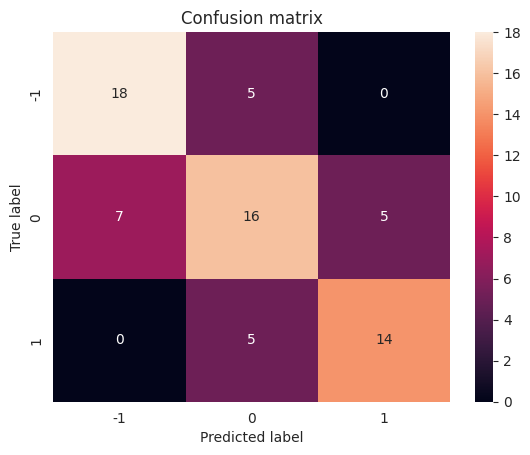

In [134]:
metric = print_metrics('MLP TF-IDF aug', y, target_enc.inverse_transform(y_preds), y_preds_proba)

In [135]:
metrics = pd.concat([metrics, metric])
metrics

,accuracy,f1,recall,precision,roc_auc_ovr,roc_auc_ovo
MLP TF-IDF,0.671429,0.675072,0.679416,0.671795,0.755827,0.759868
MLP TF-IDF + feature selection,0.614286,0.615343,0.615343,0.615343,0.715193,0.717330
CNN Word2Vec,0.585714,0.592803,0.578130,0.629426,0.694751,0.699371
CNN Word2Vec pretrained,0.614286,0.620742,0.618394,0.623522,0.743324,0.749373
CNN Glove pretrained,0.585714,0.582286,0.580255,0.595725,0.673426,0.674969
CNN OHE,0.642857,0.653439,0.650430,0.658711,0.776107,0.782336
CNN tf-idf,0.671429,0.677982,0.682467,0.674573,0.764051,0.769750
Sentence transformer,0.657143,0.666792,0.659747,0.678241,0.823455,0.831890
Sentence transformer (chunk),0.514286,0.502323,0.494388,0.564130,0.724105,0.729024
MLP TF-IDF aug,0.685714,0.693145,0.696960,0.690742,0.766128,0.771766


Удалось чуть повысить метрики, но не существенно (всего на 1%). Видимо данных все-равно недостаточно. Попытки изменить структуру сети также не увенчались успехом, колебания метрик были незначительными.

In [151]:
metrics.to_csv('metrics.csv')